In [2]:
import hashlib
import os
import sys
from os.path import realpath, join, dirname

import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from keras.layers import Dense, Input,InputLayer
from keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model
import torch
from torch import nn, optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
#  Load a pre-trained Transformer model, convert text into a format readable by the model & extract hidden representations.
from transformers import (
    AutoTokenizer,
    TrainingArguments,
    AutoModelForSequenceClassification,
    set_seed,
)

#  custom functions: include implementations for data loading, model training, evaluation metric calculation, and callbacks (early stopping)
sys.path.insert(0, realpath(join(dirname('captum_t.py'), '..')))

from util.helpers import (
    compute_metrics,
    load_dataset_with_features, get_hugging_face_name, TCCDataset, RegressionTrainer,
    compute_metrics_for_regression, OptimizedESCallback
)

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#  avoid occupying all memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

BOOTSTRAP_SIZE = 1000  # 1000
MAX_ENSEMBLE_SIZE = 2  # 60
ENSEMBLE_POOL_SIZE = 5  # 100
N_FOLDS = 2
MODEL_NAME = 'gbert'  # ['gbert', 'gelectra', 'gottbert', 'gerpt']
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
N_EVAL_STEPS = 23

EXPERIMENT_NAME = f'ensemble_{MODEL_NAME}'
EXPERIMENT_DIR = f'../autodl-tmp/cache/{EXPERIMENT_NAME}'

df_train, feature_columns = load_dataset_with_features('training')

# Make predictions with the ensemble model on a validation set; create a DataFrame for the prediction results, including ID and raw text.
# Load the tokenizer for text segmentation
# Tokenize the text in the validation set, specifying padding, truncation, and a maximum length (128) to ensure fixed-length input.
def get_predictions(
        df_train_folds,
        df_val_fold,
        n_epochs=20,
        n_log_steps=10,
):
    # store predictions in dataframe
    # columns: Sentence, Prediction of Model 1, Prediction of Model 2, ...
    df_predictions_val_fold = df_val_fold[['ID', 'Sentence DE']].copy()

    # get tokenizer
    tokenizer = AutoTokenizer.from_pretrained(get_hugging_face_name(MODEL_NAME))

    X_val_fold = df_val_fold['Sentence DE'].values
    X_val_fold_features = df_val_fold[feature_columns].values

    # tokenize
    tokens_val_fold = tokenizer(X_val_fold.tolist(), padding='max_length', return_tensors='pt', truncation=True,
                                max_length=128)
    
    for k in range(ENSEMBLE_POOL_SIZE):
        df_early_stopping = df_train_folds.sample(frac=0.1, random_state=k)
        df_train_no_es = df_train_folds.drop(
            df_train_folds[
                df_train_folds['ID'].isin(df_early_stopping['ID'])
            ].index
        )

        X_early_stopping = df_early_stopping['Sentence DE'].values
        X_early_stopping_features = df_early_stopping[feature_columns].values
        y_early_stopping = df_early_stopping['MOS'].values

        X_training = df_train_no_es['Sentence DE'].values
        X_training_features = df_train_no_es[feature_columns].values
        y_training = df_train_no_es['MOS'].values

        # tokenize
        tokens_early_stopping = tokenizer(X_early_stopping.tolist(), padding='max_length', return_tensors='pt',
                                          truncation=True, max_length=128)

        tokens_training = tokenizer(X_training.tolist(), padding='max_length', return_tensors='pt', truncation=True,
                                    max_length=128)
        
        # A unique identifier is generated by hashing. This prevents training of models on identical datasets.
        hash = (
                hashlib.sha256(
                    pd.util.hash_pandas_object(df_train_no_es['ID'], index=True).values
                ).hexdigest()
                + '_'
                + get_hugging_face_name(MODEL_NAME)[
                  get_hugging_face_name(MODEL_NAME).find('/') + 1:
                  ]
        )

        # load model and, if necessary, train it
        try:
            print(f'{EXPERIMENT_DIR}/models/{MODEL_NAME}/{hash}')
            model = AutoModelForSequenceClassification.from_pretrained(
                f'{EXPERIMENT_DIR}/models/{MODEL_NAME}/{hash}', local_files_only=True, num_labels=1
            )
        except EnvironmentError:
            # create training dataset, attempts to load a locally cached model. If the file does not exist or loading fails, the training process is initiated:
            early_stopping_dataset = TCCDataset(tokens_early_stopping, y_early_stopping)
            training_dataset = TCCDataset(tokens_training, y_training)

            training_args = TrainingArguments(
                output_dir=f'{EXPERIMENT_DIR}/{MODEL_NAME}_trainer/',
                num_train_epochs=n_epochs,
                per_device_train_batch_size=TRAIN_BATCH_SIZE,
                per_device_eval_batch_size=VALID_BATCH_SIZE,
                warmup_ratio=0.3,
                learning_rate=5e-5,
                no_cuda=False,
                metric_for_best_model='root_mean_squared_error',
                greater_is_better=False,
                load_best_model_at_end=True,
                save_steps=N_EVAL_STEPS * 100_000,
                # we never want to save a model through this function, but the parameter must be set, because of load_best_model_at_end=True
                save_total_limit=1,  # can be 1, because we only save, when we find a better model
                eval_steps=N_EVAL_STEPS,
                evaluation_strategy='steps',
                seed=k,
                logging_steps=n_log_steps,
                logging_dir=f'{EXPERIMENT_DIR}/logs/member_{k}',
                logging_strategy='steps',
            )

            set_seed(training_args.seed)
            model = AutoModelForSequenceClassification.from_pretrained(
                get_hugging_face_name(MODEL_NAME), num_labels=1
            )

            trainer = RegressionTrainer(
                model=model,
                args=training_args,
                train_dataset=training_dataset,
                eval_dataset=early_stopping_dataset,
                compute_metrics=compute_metrics_for_regression,
                callbacks=[OptimizedESCallback(patience=5, initial_steps_wo_save=300)],
            )
            # training
            trainer.train()

            # save model
            model.save_pretrained(f'{EXPERIMENT_DIR}/models/{MODEL_NAME}/{hash}')

        # fetch feature layer for captum
        hidden_state_val_fold = extract_hidden_state(model, tokens_val_fold)

        # normalize data with StandardScaler
        scaler = StandardScaler()
        scaler.fit(df_train_folds[feature_columns].values)
        X_val_fold_features_scaled = scaler.transform(X_val_fold_features)
        X_val_fold_with_features = np.concatenate((hidden_state_val_fold.detach().numpy(), X_val_fold_features_scaled),
                                                  axis=1)

        # load MLP model and, if necessary, train it
        
        # 假设 MLP 是一个自定义的 PyTorch 模型类
        # Input layer size = Transformer hidden state dimension + manual feature dimension
        # One hidden layer (with ReLU activation)
        # Output layer mapping to a single value (regression prediction)
        class MLP(nn.Module):
            def __init__(self, input_size, hidden_size):
                super(MLP, self).__init__()
                self.layers = nn.Sequential(
                    nn.Linear(input_size, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, 1)
                )
            
            def forward(self, x):
                return self.layers(x)
        
        # load or train model
        try:
            print('一定看看哈')
            
            model_path = f'{EXPERIMENT_DIR}/models/mlp/{hash}.pth'
            print(model_path)
            mlp = MLP(model.config.hidden_size + len(feature_columns), model.config.hidden_size)
            mlp.load_state_dict(torch.load(model_path))
            mlp.eval()
        
        except Exception:
            # 提取隐藏状态等操作保持不变
            hidden_state_train = extract_hidden_state(model, tokens_training)
            hidden_state_early_stopping = extract_hidden_state(model, tokens_early_stopping)
        
            np.random.seed(k)
            # 初始化模型
            mlp = MLP(model.config.hidden_size + len(feature_columns), model.config.hidden_size)
        
            # 定义损失函数和优化器
            criterion = nn.MSELoss()
            optimizer = optim.RMSprop(mlp.parameters())
        
            # 数据标准化
            scaler = StandardScaler()
            scaler.fit(X_training_features)
            X_train_features_scaled = scaler.transform(X_training_features)
            X_es_features_scaled = scaler.transform(X_early_stopping_features)
        
            X_train_with_features = np.concatenate((hidden_state_train.detach().numpy(), X_train_features_scaled), axis=1)
            X_es_with_features = np.concatenate((hidden_state_early_stopping.detach().numpy(), X_es_features_scaled), axis=1)
        
            # 将数据转换为 PyTorch 张量
            train_tensor = torch.tensor(X_train_with_features, dtype=torch.float32)
            train_labels = torch.tensor(y_training, dtype=torch.float32).view(-1, 1)
            es_tensor = torch.tensor(X_es_with_features, dtype=torch.float32)
            es_labels = torch.tensor(y_early_stopping, dtype=torch.float32).view(-1, 1)
        
            # 训练循环
            for epoch in range(200):  # 进行 50 轮训练
                optimizer.zero_grad()  # 梯度清零
                outputs = mlp(train_tensor)  # 前向传播
                loss = criterion(outputs, train_labels)  # 计算损失
                loss.backward()  # 反向传播
                optimizer.step()  # 更新参数
        
                with torch.no_grad():
                    val_outputs = mlp(es_tensor)
                    val_loss = criterion(val_outputs, es_labels)
                    print(f'Epoch [{epoch+1}/50], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
        
            # 保存模型

            torch.save(mlp.state_dict(), model_path)
        
        # 使用模型进行预测
        mlp.eval()
        with torch.no_grad():
            val_tensor = torch.tensor(X_val_fold_with_features, dtype=torch.float32)
            prediction_val_fold = mlp(val_tensor).numpy()
        
        df_predictions_val_fold[f'{MODEL_NAME}_prediction_{k}'] = prediction_val_fold
    
    return df_predictions_val_fold

# it extracts the hidden states from the final layer of the model's output
def extract_hidden_state(model, tokens, batch_size=16):
    last_last_hidden_state = torch.zeros((len(tokens.input_ids), model.config.hidden_size))
    model = model.cuda().eval()
    with torch.no_grad():
        for i in range(0, len(tokens.input_ids), batch_size):
            if i + batch_size > len(tokens.input_ids):
                input_i = tokens.input_ids[i:]
            else:
                input_i = tokens.input_ids[i:i + batch_size]
            output = model(input_i.cuda(), output_hidden_states=True)
            last_hidden_state = output.hidden_states[-1].cpu()
            idx_last_token = torch.zeros(len(input_i)).long()
            last_last_hidden_state[i:i + len(idx_last_token)] = last_hidden_state[
                torch.arange(len(idx_last_token)), idx_last_token]
    return last_last_hidden_state



2025-03-24 14:23:19.642720: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 14:23:19.664949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-24 14:23:19.687637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-24 14:23:19.694453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 14:23:19.715999: I tensorflow/core/platform/cpu_feature_guar

In [3]:

# dataframe for each metric for each model for each ensemble size
# 3d array: [ensemble_size, model_index, metric_index]
df_macro_ensemble_scores = pd.DataFrame(
    columns=[
        'ensemble_size',
        'model_name',
        'mean_absolute_error_mean',
        'mean_absolute_error_std',
        'mean_squared_error_mean',
        'mean_squared_error_std',
        'root_mean_squared_error_mean',
        'root_mean_squared_error_std',
    ]
)


In [4]:
# 做一个单独的

In [6]:
#A custom forward propagation function, During the interpretation process, Captum invokes this function and calculates the importance of each input feature based on the returned results.
def custom_forward(inputs):
    preds = predict(inputs)
    print(preds)
    return preds

In [7]:
def predict(inputs):
    #print('model(inputs): ', model(inputs))
    return model(inputs)[0]

def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

# For Bert, the input consists not only of token IDs but also includes token type IDs to distinguish between different sentence segments.
def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

# construct position ids
def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

# construct attention mask
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


In [8]:
# The AutoTokenizer is used to load the tokenizer corresponding to the model.
tokenizer = AutoTokenizer.from_pretrained(get_hugging_face_name(MODEL_NAME))
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for mark the beginning of sequences, prepending to the concatenated question-text word sequence

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import torch
import matplotlib.pyplot as plt
import captum
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
                f'{EXPERIMENT_DIR}/models/{MODEL_NAME}/3221b14132ce1811b5cd73c4108382bd480e30138c2fadf6908e413349c00d49_gbert-large', local_files_only=True, num_labels=1
            ).to(device)

lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)

In [10]:
text =  "Kochbücher propagierten ab 1651 die „Haute Cuisine“, die von den ersten Restaurants fortan adaptiert wurde." #"The movie was one of those amazing movies"#"The movie was one of those amazing movies you can not forget"


In [11]:
# Constructs input and reference input
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)

# Constructs token type information
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)

# Constructs position ID information
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)

# Generates attention masks
attention_mask = construct_attention_mask(input_ids)

# Retrieves the corresponding string representations of tokens
indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [12]:
##saved_act = None
def save_act(module, inp, out):
  #global saved_act
  saved_act = out
  return saved_act

# test hook
hook = model.bert.embeddings.register_forward_hook(save_act)

In [13]:
hook.remove()

In [14]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]], device='cuda:0')

In [15]:
# Check predict output
custom_forward(torch.cat([input_ids]).to(device))
input_ids.shape

tensor([[3.2616]], device='cuda:0', grad_fn=<AddmmBackward0>)


torch.Size([1, 29])

In [16]:
pred = predict(input_ids)
torch.softmax(pred, dim = 1)


tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [17]:
# Check output of custom_forward
custom_forward(input_ids).cpu().detach().numpy()

tensor([[3.2616]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([[3.2615592]], dtype=float32)

In [18]:
# constract the input of BERT
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

In [19]:
# Captum's attribution methods compute the contribution score of each token to the model's output.
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

In [20]:
# Captum: compute the contribution score of each token to the model's output.
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

In [21]:
#layer_attrs_start = []
layer_attrs = []



input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)


# captum work
for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
    #layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings)
    layer_attributions = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings)
    #layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs.append(summarize_attributions(layer_attributions).cpu().detach().tolist())


In [22]:
xticklabels=all_tokens

In [23]:
xticklabels

['[CLS]',
 'Koch',
 '##bücher',
 'propag',
 '##ierten',
 'ab',
 '165',
 '##1',
 'die',
 '„',
 'Haut',
 '##e',
 'Cu',
 '##isi',
 '##ne',
 '“',
 ',',
 'die',
 'von',
 'den',
 'ersten',
 'Restaurants',
 'fortan',
 'ad',
 '##ap',
 '##tiert',
 'wurde',
 '.',
 '[SEP]']

In [107]:
np.mean(np.array(layer_attrs),axis=0)

array([ 0.08290801, -0.05249229,  0.10127155,  0.36656749,  0.07800661,
        0.02380109,  0.19420964,  0.05539912,  0.13614352,  0.21676602,
        0.37085181,  0.07609207, -0.00092538,  0.01530746,  0.09094104,
        0.10936626,  0.16336048,  0.14793985,  0.11470334,  0.1096538 ,
        0.1154531 ,  0.04561547,  0.24581056, -0.03978275, -0.16432641,
       -0.01091025,  0.07321978,  0.16647994,  0.07599755])

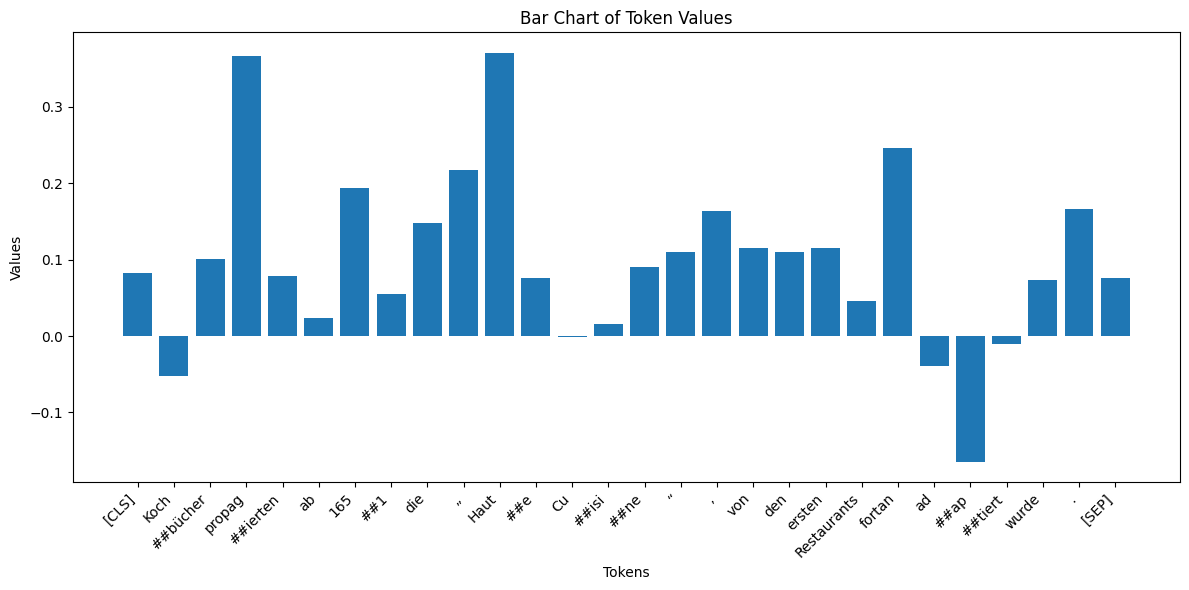

In [26]:
values = np.mean(np.array(layer_attrs),axis=0) #取所有层的平均值
# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(xticklabels, values)

# 添加标签和标题
plt.xlabel('Tokens')
plt.ylabel('Values')
plt.title('Bar Chart of Token Values')

# 旋转x轴标签以便更好地显示
plt.xticks(rotation=45, ha='right')

# 显示图形
plt.tight_layout()
plt.show()


In [115]:
# Merging Subword Contributions, marked by "##"
merged_words = []
merged_values = []
temp_word = ""
temp_value = 0

for word, value in zip(xticklabels, values):
    if word.startswith('##'):
        temp_word += word[2:]
        temp_value += value
    else:
        if temp_word:
            merged_words.append(temp_word)
            merged_values.append(temp_value)
            temp_word = ""
            temp_value = 0
        temp_word = word
        temp_value = value

if temp_word:
    merged_words.append(temp_word)
    merged_values.append(temp_value)

# 贡献值最大的前三项
top_five_indices = sorted(range(len(merged_values)), key=lambda i: merged_values[i], reverse=True)[:5]
top_five_words = [merged_words[i] for i in top_five_indices]
top_five_values = [merged_values[i] for i in top_five_indices]

print("Top five words :", top_five_words)
print("contribution values:", top_five_values)




Top five words : ['Haute', 'propagierten', '1651']
contribution values: [0.4469438809222387, 0.444574096684543, 0.2496087642988035]


In [110]:
# Check output of custom_forward
custom_forward(input_ids).cpu().detach().numpy()

tensor([[3.2616]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([[3.2615592]], dtype=float32)

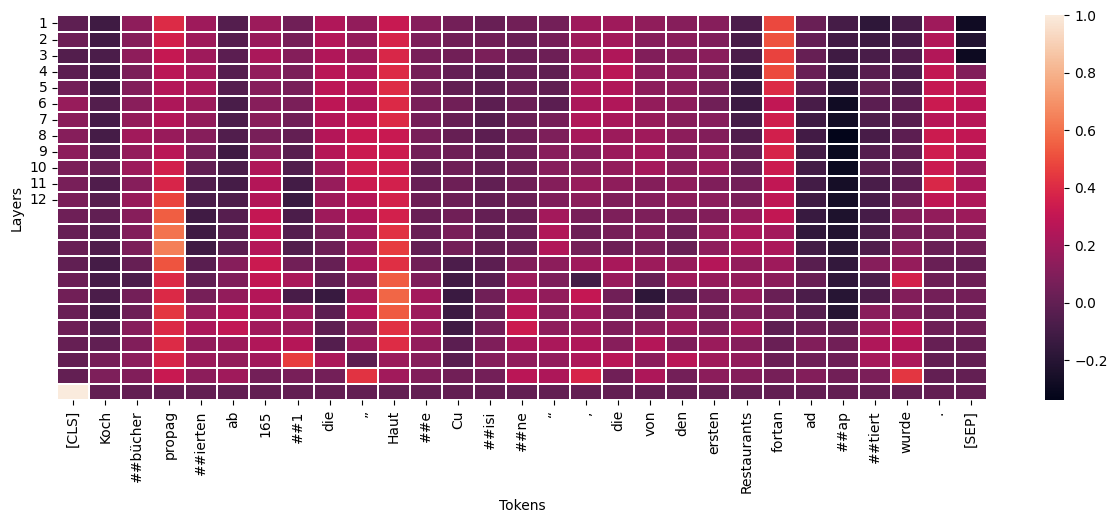

In [88]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,5))

yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

In [55]:
attributions_main, delta_main = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=7000,
                                    internal_batch_size=3,
                                    return_convergence_delta=True)

In [56]:
attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=7000,
                                    internal_batch_size=5,
                                    return_convergence_delta=True)

In [57]:
torch.sum(attributions_main), torch.sum(attributions)

(tensor(0., device='cuda:0', dtype=torch.float64),
 tensor(0., device='cuda:0', dtype=torch.float64))

In [58]:
delta, delta_main

(tensor([0.], device='cuda:0', dtype=torch.float64),
 tensor([0.], device='cuda:0', dtype=torch.float64))

In [59]:
torch.argmax(score[0]).cpu().numpy()

NameError: name 'score' is not defined

In [ ]:
torch.softmax(score, dim = 1)[0][1].cpu().detach().numpy()

In [64]:
input_ids

tensor([[  102,  7245, 10938, 29656,  1082,   404, 24959, 30908,   128,   498,
          6756, 30881, 23205, 15631,   382,  2087,   818,   128,   195,   190,
           940,  9276, 15993,  3668,   496,  1707,   325,   566,   103]],
       device='cuda:0')

In [61]:
score

tensor([[3.2616]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [60]:
score = predict(input_ids)

print('Sentence: ', text)
print('Sentiment: ' + str(torch.argmax(score[0]).cpu().numpy()) + \
      ', Probability positive: ' + str(torch.softmax(score, dim = 1)[0][1].cpu().detach().numpy()))

Sentence:  Kochbücher propagierten ab 1651 die „Haute Cuisine“, die von den ersten Restaurants fortan adaptiert wurde.


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [ ]:
attributions_sum = summarize_attributions(attributions)

In [ ]:
# storing couple samples in an array for visualization purposes
score_vis = viz.VisualizationDataRecord(attributions_sum,
                                        torch.softmax(score, dim = 1)[0][0],
                                        torch.argmax(torch.softmax(score, dim = 1)[0]),
                                        1,
                                        text,
                                        attributions_sum.sum(),       
                                        all_tokens,
                                        delta)


In [ ]:
print('\033[1m', 'Visualization For Score', '\033[0m')
viz.visualize_text([score_vis])

In [ ]:
score

In [26]:
def get_predictions_captum(
        df_train_folds,
        df_val_fold,
        n_epochs=20,
        n_log_steps=10,
):
    # store predictions in dataframe
    # columns: Sentence, Prediction of Model 1, Prediction of Model 2, ...
    df_predictions_val_fold = df_val_fold[['ID', 'Sentence DE']].copy()

    # get tokenizer
    tokenizer = AutoTokenizer.from_pretrained(get_hugging_face_name(MODEL_NAME))

    X_val_fold = df_val_fold['Sentence DE'].values
    X_val_fold_features = df_val_fold[feature_columns].values

    # tokenize
    tokens_val_fold = tokenizer(X_val_fold.tolist(), padding='max_length', return_tensors='pt', truncation=True,
                                max_length=128)

    for k in range(ENSEMBLE_POOL_SIZE):
        df_early_stopping = df_train_folds.sample(frac=0.1, random_state=k)
        df_train_no_es = df_train_folds.drop(
            df_train_folds[
                df_train_folds['ID'].isin(df_early_stopping['ID'])
            ].index
        )

        X_early_stopping = df_early_stopping['Sentence DE'].values
        X_early_stopping_features = df_early_stopping[feature_columns].values
        y_early_stopping = df_early_stopping['MOS'].values

        X_training = df_train_no_es['Sentence DE'].values
        X_training_features = df_train_no_es[feature_columns].values
        y_training = df_train_no_es['MOS'].values

        # tokenize
        tokens_early_stopping = tokenizer(X_early_stopping.tolist(), padding='max_length', return_tensors='pt',
                                          truncation=True, max_length=128)

        tokens_training = tokenizer(X_training.tolist(), padding='max_length', return_tensors='pt', truncation=True,
                                    max_length=128)

        hash = (
                hashlib.sha256(
                    pd.util.hash_pandas_object(df_train_no_es['ID'], index=True).values
                ).hexdigest()
                + '_'
                + get_hugging_face_name(MODEL_NAME)[
                  get_hugging_face_name(MODEL_NAME).find('/') + 1:
                  ]
        )


        print(f'{EXPERIMENT_DIR}/models/{MODEL_NAME}/{hash}')
        model = AutoModelForSequenceClassification.from_pretrained(
            f'{EXPERIMENT_DIR}/models/{MODEL_NAME}/{hash}', local_files_only=True, num_labels=1
        )

        # load hidden states of model for validation and test data
        hidden_state_val_fold = extract_hidden_state(model, tokens_val_fold)

        # normalize data with StandardScaler
        scaler = StandardScaler()
        scaler.fit(df_train_folds[feature_columns].values)
        X_val_fold_features_scaled = scaler.transform(X_val_fold_features)
        X_val_fold_with_features = np.concatenate((hidden_state_val_fold.detach().numpy(), X_val_fold_features_scaled),
                                                  axis=1)

        # load MLP model and, if necessary, train it

    
        # 假设 MLP 是一个自定义的 PyTorch 模型类
        class MLP(nn.Module):
            def __init__(self, input_size, hidden_size):
                super(MLP, self).__init__()
                self.layers = nn.Sequential(
                    nn.Linear(input_size, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, 1)
                )
            
            def forward(self, x):
                return self.layers(x)
        
        # 加载或训练模型

        print('一定看看哈')
        
        model_path = f'{EXPERIMENT_DIR}/models/mlp/{hash}.pth'
        print(model_path)
        mlp = MLP(model.config.hidden_size + len(feature_columns), model.config.hidden_size)
        mlp.load_state_dict(torch.load(model_path))
        # 使用模型进行预测
        mlp.eval()
        with torch.no_grad():
            val_tensor = torch.tensor(X_val_fold_with_features, dtype=torch.float32)
            prediction_val_fold = mlp(val_tensor).numpy()
        #print(prediction_val_fold)
        #print(len(prediction_val_fold))
        df_predictions_val_fold[f'{MODEL_NAME}_prediction_{k}'] = prediction_val_fold
    
    return df_predictions_val_fold

In [20]:
for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=N_FOLDS).split(df_train)):
    df_train_folds = df_train.loc[train_idx]
    df_val_fold = df_train.loc[val_idx]
    # fill na with mean of columns of train data
    df_train_folds = df_train_folds.fillna(df_train_folds.mean(numeric_only=True))
    df_val_fold = df_val_fold.fillna(df_train_folds.mean(numeric_only=True))

    y_val_fold = df_val_fold['MOS'].values

    pool_predictions_val_fold = get_predictions_captum(df_train_folds, df_val_fold)

    for current_ensemble_size in range(1, MAX_ENSEMBLE_SIZE + 1):
        np.random.seed(current_ensemble_size)
        idx = np.random.choice(
            5,
            size=(BOOTSTRAP_SIZE, current_ensemble_size),
        )

        idx_mapped = np.array(
            [
                np.array(
                    [pool_predictions_val_fold[f'{MODEL_NAME}_prediction_{k}'] for k in j]
                )
                for j in idx
            ]
        )

        ensemble_predictions = np.array(
            [np.sum(j, axis=0) / len(j) for j in idx_mapped]
        )

        print('测一下')
        print(ensemble_predictions[0])
        print(len(y_val_fold))
        ensemble_scores = [
            compute_metrics(y_val_fold, pred) for pred in ensemble_predictions
        ]


        df_ensemble_scores = pd.DataFrame(ensemble_scores).sort_index(axis=1)


../autodl-tmp/cache/ensemble_gbert/models/gbert/f402bc3bb23ca33d99e56a97d3a2fe6367a51eaa2d91ab6a2c30ca2a720ba61c_gbert-large
一定看看哈
../autodl-tmp/cache/ensemble_gbert/models/mlp/f402bc3bb23ca33d99e56a97d3a2fe6367a51eaa2d91ab6a2c30ca2a720ba61c_gbert-large.pth
500
../autodl-tmp/cache/ensemble_gbert/models/gbert/b99a5fa574e336b6ce273fbd95a4364f9490cdef9a3ca0523374dd01f2ab7bb6_gbert-large


/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


一定看看哈
../autodl-tmp/cache/ensemble_gbert/models/mlp/b99a5fa574e336b6ce273fbd95a4364f9490cdef9a3ca0523374dd01f2ab7bb6_gbert-large.pth
500
../autodl-tmp/cache/ensemble_gbert/models/gbert/be59e5c80374f5116879ba4bcef1744a41554b8523058121eb06afda8be9b438_gbert-large


/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


一定看看哈
../autodl-tmp/cache/ensemble_gbert/models/mlp/be59e5c80374f5116879ba4bcef1744a41554b8523058121eb06afda8be9b438_gbert-large.pth
500
../autodl-tmp/cache/ensemble_gbert/models/gbert/3221b14132ce1811b5cd73c4108382bd480e30138c2fadf6908e413349c00d49_gbert-large


/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


一定看看哈
../autodl-tmp/cache/ensemble_gbert/models/mlp/3221b14132ce1811b5cd73c4108382bd480e30138c2fadf6908e413349c00d49_gbert-large.pth
500
../autodl-tmp/cache/ensemble_gbert/models/gbert/16fbad104cd49cc34407917a0564260a5a164c1025737f587630f80c0c845ad1_gbert-large


/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


一定看看哈
../autodl-tmp/cache/ensemble_gbert/models/mlp/16fbad104cd49cc34407917a0564260a5a164c1025737f587630f80c0c845ad1_gbert-large.pth
500
测一下
[ 4.2674556   1.0182894   2.865158    2.3436015   1.8491752   3.308426
  2.5216303   1.6614823   4.593692    0.9166553   3.372873    1.9728893
  3.186903    2.5171115   0.64032495  4.3379464   1.3235046   1.9399192
  3.8807087   0.81975317  2.7062716   2.5472844   1.8927562   1.4335063
  4.677681    2.6725528   1.9858568   3.0995033  -1.2653286   2.1727583
 -0.12882587  2.3794463   1.8579988   2.1764932   3.0938447   3.32424
  0.2652974   5.4412675   0.8768339   2.730119    3.301856    3.929454
  2.474055    3.638127    2.351018    4.0699773   0.40941495  4.1614256
  1.6724936   2.0076134   2.7520761   0.5354818   4.697951    2.0646992
  2.9472558   2.6765215   2.5232542   3.5417857   5.543149    1.7719969
  2.2106745   4.1171756   1.9411465   2.8846443   4.1846166   3.28376
  2.6067333   2.1733952   3.0081801   0.9207324   1.8048156   2.8176959
 

/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


测一下
[ 3.1505282   2.7443612   2.7412062   1.5818461   2.4962308   2.097626
  4.271709    1.0867188   3.2608058   1.5017034   2.1059425   2.3782613
  2.478131    2.7694046   1.4241655   5.350113    1.5498139   2.150611
  3.5069468   1.8854455   3.135497    3.0598521   2.1939282   1.8254193
  5.745371    3.2439823   2.316991    2.6882174   1.242011    2.1906497
  1.3163682   2.6510203   1.340946    2.1490662   3.2255645   3.7114189
  2.25302     5.221505    1.4382868   2.3443117   2.988025    2.8891242
  3.5777514   1.995902    3.4312062   2.9438534   0.11610667  3.3429532
  1.820067    1.4936244   2.5349236   0.51608515  7.2103467   0.912108
  2.3161266   1.5157895   2.784743    3.5624368   5.456546    2.8444002
  2.9196143   3.9428236   1.7538791   2.8763514   5.1798363   4.136867
  2.1726928   1.911574    2.6372116   0.6481578   1.5548652   2.457895
  1.5042866   7.4121375   5.725601    2.2883773   2.5795689   2.0364802
  1.3535962   2.2576349   4.847535    4.6934886   2.6038086   0.8

/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


一定看看哈
../autodl-tmp/cache/ensemble_gbert/models/mlp/da7daa20b041aae767afab50a06cd0292073a44da2495631b4af8bd23383014e_gbert-large.pth
500
../autodl-tmp/cache/ensemble_gbert/models/gbert/26ead4461bdab0fa6e757cc0bb6fb119bba5b7b36714ebe10f4a128d25af2ce3_gbert-large


/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


一定看看哈
../autodl-tmp/cache/ensemble_gbert/models/mlp/26ead4461bdab0fa6e757cc0bb6fb119bba5b7b36714ebe10f4a128d25af2ce3_gbert-large.pth
500
../autodl-tmp/cache/ensemble_gbert/models/gbert/5c449f56f076f32e703faa34fa8c116ad527e42a4ec0b8d664862a2493fdac08_gbert-large


/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


一定看看哈
../autodl-tmp/cache/ensemble_gbert/models/mlp/5c449f56f076f32e703faa34fa8c116ad527e42a4ec0b8d664862a2493fdac08_gbert-large.pth
500
../autodl-tmp/cache/ensemble_gbert/models/gbert/671bfad85116e6f03d257b3f5c0c1e1551066e8888c5f1169be26599b41d74b9_gbert-large


/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


一定看看哈
../autodl-tmp/cache/ensemble_gbert/models/mlp/671bfad85116e6f03d257b3f5c0c1e1551066e8888c5f1169be26599b41d74b9_gbert-large.pth
500
测一下
[ 2.5758193e+00  5.0811279e-01  5.7788283e-01  3.2802367e+00
  1.5226611e+00  3.7313530e+00  1.7600130e+00  3.6949151e+00
  3.3070560e+00  3.8252771e+00  3.3181627e+00  1.5158789e+00
  3.8023007e+00  3.0509126e+00  2.2715311e+00  3.0535107e+00
  2.3752642e+00  2.7251711e+00  2.3085310e+00  2.0962081e+00
  2.2478559e+00  3.2776108e+00  2.3929207e+00  3.2348633e+00
  2.1814356e+00  3.8196974e+00  2.5826831e+00  3.3320227e+00
  3.0208697e+00  3.1374159e+00  2.5140436e+00  1.7620260e+00
  4.3010640e+00  2.9959843e+00  3.3949876e+00  2.1591041e+00
  4.5031652e+00  9.7742069e-01  4.1212883e+00  5.4513674e+00
  1.9841840e+00  2.5492361e+00  2.5032430e+00  1.6691515e+00
  1.5265844e+00  4.2998443e+00  3.9502351e+00  3.3160849e+00
  2.1976655e+00  1.5257225e+00  3.7291949e+00  1.1074681e+00
  3.8014381e+00  3.4165163e+00  2.5438409e+00  3.3009186e-01
  2.3

/tmp/ipykernel_1321/2356263958.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load(model_path))


测一下
[ 1.1716529   2.5587232   1.6503814   1.1473789   2.127459    2.2652655
  1.2310501   1.5658362   3.5275505   3.1217344   2.814321   -0.6671246
  3.4055166   3.0326025   1.2614976   2.1464958   2.1955311   1.2079971
  1.570755    2.547632    2.2712514   1.8890917   2.2382197   2.8316393
  1.8931237   3.2060723   1.8931773   2.774956    2.5776844   2.8791912
  2.347082    0.9491122   4.5271873   2.7729354   1.9208785   2.10891
  2.5963626   1.4299604   3.0065413   6.586666    2.6084113   3.1051316
  2.0614605   2.9142373   2.6301186   3.4143429   4.03714     3.519846
  1.9573476   2.4711595   2.7303827   2.6599114   1.9843751   2.2253659
  3.11079     1.9467427   2.6191373   2.9913623   2.8420172   1.8616112
  7.9018364   0.14416638  1.588696    2.6053877   1.7430345   2.0887067
  1.8290136   2.1953382   3.8211474  -0.09259722  1.2529081   1.5498235
  1.1405776   6.210458    3.031356    5.1991963   2.6494608   2.0625346
  4.323918    7.1980624   1.1145393   1.5122318   1.3778625   1

In [ ]:

for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=N_FOLDS).split(df_train)):
    df_train_folds = df_train.loc[train_idx]
    df_val_fold = df_train.loc[val_idx]
    # fill na with mean of columns of train data
    df_train_folds = df_train_folds.fillna(df_train_folds.mean(numeric_only=True))
    df_val_fold = df_val_fold.fillna(df_train_folds.mean(numeric_only=True))

    y_val_fold = df_val_fold['MOS'].values

    pool_predictions_val_fold = get_predictions(df_train_folds, df_val_fold)

    for current_ensemble_size in range(1, MAX_ENSEMBLE_SIZE + 1):
        np.random.seed(current_ensemble_size)
        idx = np.random.choice(
            ENSEMBLE_POOL_SIZE,
            size=(BOOTSTRAP_SIZE, current_ensemble_size),
        )

        idx_mapped = np.array(
            [
                np.array(
                    [pool_predictions_val_fold[f'{MODEL_NAME}_prediction_{k}'] for k in j]
                )
                for j in idx
            ]
        )

        ensemble_predictions = np.array(
            [np.sum(j, axis=0) / len(j) for j in idx_mapped]
        )

        print('测一下')
        print(ensemble_predictions[0:5])
        print(y_val_fold[0:5])
        
        ensemble_scores = [
            compute_metrics(y_val_fold, pred) for pred in ensemble_predictions
        ]

        df_ensemble_scores = pd.DataFrame(ensemble_scores).sort_index(axis=1)

        # add to dataframe
        df_macro_ensemble_scores = df_macro_ensemble_scores._append(
            {
                'ensemble_size': current_ensemble_size,
                'model_name': MODEL_NAME,
                'mean_absolute_error_mean': df_ensemble_scores[
                    'mean_absolute_error'
                ].mean(),
                'mean_absolute_error_std': df_ensemble_scores[
                    'mean_absolute_error'
                ].std(),
                'mean_squared_error_mean': df_ensemble_scores[
                    'mean_squared_error'
                ].mean(),
                'mean_squared_error_std': df_ensemble_scores[
                    'mean_squared_error'
                ].std(),
                'root_mean_squared_error_mean': df_ensemble_scores[
                    'root_mean_squared_error'
                ].mean(),
                'root_mean_squared_error_std': df_ensemble_scores[
                    'root_mean_squared_error'
                ].std(),
            },
            ignore_index=True,
        )


# write to csv for each model_name
df_macro_ensemble_scores[
    df_macro_ensemble_scores['model_name'] == MODEL_NAME
    ].to_csv(
    f'ensemble_scores_{MODEL_NAME}.csv', index=False, sep=',', encoding='utf-8'
)


In [ ]:

for fold, (train_idx, val_idx) in enumerate(KFold(n_splits=N_FOLDS).split(df_train)):
    df_train_folds = df_train.loc[train_idx]
    df_val_fold = df_train.loc[val_idx]
    # fill na with mean of columns of train data
    df_train_folds = df_train_folds.fillna(df_train_folds.mean(numeric_only=True))
    df_val_fold = df_val_fold.fillna(df_train_folds.mean(numeric_only=True))

    y_val_fold = df_val_fold['MOS'].values

    pool_predictions_val_fold = get_predictions(df_train_folds, df_val_fold)

    for current_ensemble_size in range(1, MAX_ENSEMBLE_SIZE + 1):
        np.random.seed(current_ensemble_size)
        idx = np.random.choice(
            ENSEMBLE_POOL_SIZE,
            size=(BOOTSTRAP_SIZE, current_ensemble_size),
        )

        idx_mapped = np.array(
            [
                np.array(
                    [pool_predictions_val_fold[f'{MODEL_NAME}_prediction_{k}'] for k in j]
                )
                for j in idx
            ]
        )

        ensemble_predictions = np.array(
            [np.sum(j, axis=0) / len(j) for j in idx_mapped]
        )

        print('测一下')
        print(ensemble_predictions[0:5])
        print(y_val_fold[0:5])
        ensemble_scores = [
            compute_metrics(y_val_fold, pred) for pred in ensemble_predictions
        ]

        df_ensemble_scores = pd.DataFrame(ensemble_scores).sort_index(axis=1)

        # add to dataframe
        df_macro_ensemble_scores = df_macro_ensemble_scores._append(
            {
                'ensemble_size': current_ensemble_size,
                'model_name': MODEL_NAME,
                'mean_absolute_error_mean': df_ensemble_scores[
                    'mean_absolute_error'
                ].mean(),
                'mean_absolute_error_std': df_ensemble_scores[
                    'mean_absolute_error'
                ].std(),
                'mean_squared_error_mean': df_ensemble_scores[
                    'mean_squared_error'
                ].mean(),
                'mean_squared_error_std': df_ensemble_scores[
                    'mean_squared_error'
                ].std(),
                'root_mean_squared_error_mean': df_ensemble_scores[
                    'root_mean_squared_error'
                ].mean(),
                'root_mean_squared_error_std': df_ensemble_scores[
                    'root_mean_squared_error'
                ].std(),
            },
            ignore_index=True,
        )


# write to csv for each model_name
df_macro_ensemble_scores[
    df_macro_ensemble_scores['model_name'] == MODEL_NAME
    ].to_csv(
    f'ensemble_scores_{MODEL_NAME}.csv', index=False, sep=',', encoding='utf-8'
)
